# Segmentation and MBA based on cluster labels

In [1]:
import pandas as pd
import numpy as np
import time
import glob
from math import ceil

# association rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import preprocessing

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import OPTICS
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import pandas.plotting

print('--- packages imported ---')

--- packages imported ---


In [2]:
!export PYTHONWARNINGS="ignore"

In [3]:
!ls

BC3_Instacart.pdf                  departments.csv
BC3_Report.docx                    img
README.md                          order_products.csv
_Clustering Analysis and MBA.ipynb orders.csv
_EDA.ipynb                         products.csv
_MBA.ipynb


## Import datasets

In [4]:
departments = pd.read_csv('departments.csv')
order_prod = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

## 1. Preprocessing and Transformation

In [5]:
df = pd.merge(order_prod, products, how='left', on='product_id').\
    drop(["product_id", "department_id"], axis=1)
df.head()

,order_id,product_name
0,10,fresh fruits
1,10,fresh vegetables
2,10,fresh herbs
3,10,fresh fruits
4,10,fresh vegetables


In [6]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2425083,49125,1,2,18,NaN
1,1944304,162867,1,3,17,NaN
2,1201011,147243,14,0,16,3.0
3,1906860,195275,81,1,11,3.0
4,2766469,58222,3,6,11,6.0


The column *days_since_prior_order* has 12254 *Nan* values which is due to the obvious lack of information when a customer has made purchase for the first time. Hence, for first time customers, the *days_since_prior_order* is *Nan*. <br> <br>
**As a result, we need to identify these customers and create a seperate dataframe if we want to integrate the feature *days_since_prior_order* in our clustering algorithm.**

### 1.1. Reshaping data to have user_id as index
We will employ a customer segmentation to group Instacarts shoopers according to their purchases. That is, we need to reshape and transform the data.

In [7]:
op_merged = pd.merge(order_prod, products, how='left', on='product_id')
op_merged = pd.merge(op_merged, departments, on='department_id', how='left')
op_merged_pt = op_merged.drop(["product_id","department_id","department"], axis=1)

In [105]:
op_merged_pt

,order_id,product_name
0,10,fresh fruits
1,10,fresh vegetables
2,10,fresh herbs
3,10,fresh fruits
4,10,fresh vegetables
...,...,...
2019496,3420578,asian foods
2019497,3420578,fresh herbs
2019498,3420693,ice cream ice
2019499,3420693,ice cream ice


In [8]:
# use crosstab to pivot data
pt_cross = pd.crosstab(op_merged_pt['order_id'], op_merged_pt['product_name'])
# check sum of all purchases made. Important info to check if our transformation was successful at the end.
pt_cross.values.sum()

2019501

In [9]:
# merge pivoted order df with user_id 
pt_merge = pd.merge(pt_cross.reset_index(), orders, how='left', on='order_id')
pt_merge = pt_merge.drop(pt_merge.columns[-4:], axis=1).drop("order_id", axis=1)

In [10]:
# melt df on user_id
pt_melt = pd.melt(pt_merge, id_vars=['user_id'], value_vars=pt_merge.columns[:-1])
pt_melt = pt_melt.groupby(["user_id", "variable"])["value"].sum().reset_index()

In [11]:
# pivot data to get all purchases (columns= product types) made by the user (row)
pt_pivot = pt_melt.pivot_table(index="user_id", columns='variable', values='value')
pt_pivot.head()

variable,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,0,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,2,0,0


In [12]:
# Check if transformation was successful and matches original df length. It does!
pt_pivot.values.sum()

2019501

In [13]:
pt_pivot.shape

(105273, 134)

### 1.2. Separating the new customers (with days since prior purchases = Nan) from the customer with +1 purchase

To perform Clustering we decided to drop all rows that contain Nan values in date since prior order, since keeping them or attributing a number to those Nan values would bias our results. That is we have **105273** customers, **12254** being new customers. BUT, since a new customer could order multiple times in the given period it would be wrong to delete them. So, we deleted only the new customers that shopped one time and one time only as well as the first orders of the new customers containing the Nan values. At end end we are left with **98918** that shopped at least twice in the given period/dataset.

In [14]:
orders_df = orders.copy()

In [15]:
orders_df.set_index('order_id',inplace=True)

In [16]:
new_cus = orders_df[orders_df['days_since_prior_order'].isnull()]
new_cus.drop(columns=['days_since_prior_order'], inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
orders_cust = orders_df[orders_df['days_since_prior_order'].notna()]

In [18]:
if (new_cus.shape[0] + orders_cust.shape[0] == orders_df.shape[0]) == True:
    print('New customer orders:',new_cus.shape[0])
    print('Current customer orders:',orders_cust.shape[0])
    print('Slicing successful!')

New customer orders: 12254
Current customer orders: 187746
Slicing successful!


**Aggregating the orders_cust df as follows:** <br>
Taking the max order_numer, <br> mean day_since_prior_order, <br> mean order_dow, <br> mean order_hour_of_day.

In [19]:
users_df = orders_cust.groupby('user_id').agg({'order_number':'max',
                                             'days_since_prior_order':'mean',
                                             'order_dow':'mean',
                                             'order_hour_of_day':'mean'})\
                               .rename(columns={"order_number":"purchases"})
users_df.head()

,purchases,days_since_prior_order,order_dow,order_hour_of_day
user_id,,,,
2,3,6.500000,3.000000,10.000000
3,11,13.333333,1.666667,18.333333
7,3,30.000000,0.000000,18.000000
10,4,14.000000,3.000000,15.000000
11,5,30.000000,5.000000,11.000000


In [20]:
users_df.shape

(98918, 4)

### 1.3. Merging the new user_df with our pt_pivot which entails consumption behaviour data


In [21]:
all_users_df = users_df.merge(pt_pivot, how='left', on='user_id')
all_users_df.head()

,purchases,days_since_prior_order,order_dow,order_hour_of_day,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
2,3,6.500000,3.000000,10.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,13.333333,1.666667,18.333333,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
7,3,30.000000,0.000000,18.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,4,14.000000,3.000000,15.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,5,30.000000,5.000000,11.000000,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,0,0


In [22]:
# Check
print(len(all_users_df.index))
print(len(all_users_df.index.unique()))

98918
98918


### 1.4. Scaling the Data

In [23]:
df_before = all_users_df.copy()

cols = all_users_df.columns
rows = all_users_df.index

dic = {}
i = 0

for element in cols:
    dic[i]=element
    i = i + 1

x = all_users_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)
df_scaled = df_scaled.rename(columns=dic)
df_scaled.head()

,purchases,days_since_prior_order,order_dow,order_hour_of_day,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0.010204,0.216667,0.500000,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.091837,0.444444,0.277778,0.797101,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.000000
2,0.010204,1.000000,0.000000,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.007143
3,0.020408,0.466667,0.500000,0.652174,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.007143
4,0.030612,1.000000,0.833333,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.000000


### 1.4. Performing PCA for Dimensionality Reduction

In [24]:
def explained_variance(dataframe):
    """Calculates the Eigenvalues for each Principal Component in a dataframe."""
    
    pca = PCA()
    pca_feat = pca.fit_transform(dataframe)
    
    return np.cumsum(pca.explained_variance_ratio_), pca.n_components_

In [25]:
def get_principal_components(dataframe, nPC):
    """Gets PC values for each observation in dataframe and creates new dataframe."""
    
    pca = PCA(nPC)
    pca_feat = pca.fit_transform(dataframe)
    pca_names = [f"PC{i}" for i in range(pca.n_components_)]
    pca_df = pd.DataFrame(pca_feat, index=dataframe.index, columns=pca_names)
    return pca_df

In [26]:
explained_variance(df_scaled)

(array([0.27192185, 0.5086467 , 0.58640197, 0.65466772, 0.67995344,
        0.69016915, 0.69873972, 0.70698652, 0.71477093, 0.72195173,
        0.72898325, 0.73550944, 0.74176419, 0.74786375, 0.75362461,
        0.75928461, 0.76433432, 0.76920514, 0.7738792 , 0.77847542,
        0.7828491 , 0.78719961, 0.79148383, 0.79572777, 0.79978451,
        0.80378409, 0.80768931, 0.81156896, 0.81539207, 0.81919294,
        0.82279205, 0.82635953, 0.82983152, 0.83328   , 0.83668492,
        0.84003827, 0.84333359, 0.84660024, 0.84976182, 0.85286876,
        0.85592691, 0.85894559, 0.86194403, 0.86492373, 0.8678456 ,
        0.87073094, 0.87357073, 0.8763628 , 0.87913975, 0.88186761,
        0.88450085, 0.8871207 , 0.8897037 , 0.89226327, 0.89477953,
        0.89726265, 0.8997285 , 0.90218019, 0.90459977, 0.90700771,
        0.90938881, 0.91175227, 0.91409163, 0.9164004 , 0.91868971,
        0.92093017, 0.92316565, 0.92530186, 0.9274032 , 0.92945536,
        0.93149962, 0.93348501, 0.93543489, 0.93

**Result:** <br> PCA 10, subjective assessment

In [27]:
scaled = get_principal_components(df_scaled, 10)

In [28]:
scaled

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.160751,0.009794,-0.173143,0.199828,0.023176,-0.012167,-0.026191,0.029809,-0.029764,0.034095
1,-0.062577,-0.172641,-0.093880,-0.192661,0.024530,-0.049995,-0.018040,0.003945,-0.019667,0.070942
2,-0.656021,-0.343061,0.015032,-0.199400,0.019417,-0.024537,-0.025848,-0.017713,-0.057625,0.006793
3,-0.052328,0.049258,-0.064274,-0.053157,0.191101,0.120587,-0.081717,-0.035365,-0.028487,-0.092690
4,-0.491170,0.473390,0.105764,0.096871,0.004903,0.010520,0.133688,-0.050151,-0.030600,0.054410
...,...,...,...,...,...,...,...,...,...,...
98913,0.089191,0.361842,-0.078113,0.267075,0.110682,-0.046221,0.002142,-0.016833,-0.094060,-0.085668
98914,0.110528,0.360492,-0.204733,-0.057756,-0.005510,0.002282,-0.002106,0.016745,-0.016592,0.011078
98915,0.384999,-0.242268,0.116580,-0.199926,-0.187555,-0.037991,0.000367,-0.011415,-0.007285,-0.065444
98916,0.223731,-0.257199,0.231551,-0.014102,-0.096822,0.020986,0.099268,0.070075,-0.015590,0.016467


## 2. Clustering Shoppers

#### Please be aware that the allocation and cluster numbers could eventually change when running the cell below

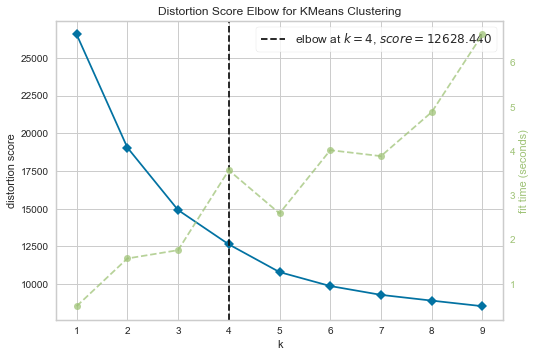

In [29]:
# KMEANS Elbow
model = KMeans(scaled)
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(scaled)    
visualizer.show()       # Finalize and render the figure

### 2.1. Running K-Means with 4 clusters and random_state = 27

In [30]:
number_clusters = 4
kmeans = KMeans(
    n_clusters=number_clusters, 
    init='k-means++',
    n_init=10, 
    random_state=27,
    tol= 1e-4)

km_labels = kmeans.fit_predict(df_scaled)
km_labels

array([0, 1, 2, ..., 3, 3, 0], dtype=int32)

### 2.2. Merging cluster labels with original df

In [31]:
all_users_df.reset_index(drop=True,inplace=True)

In [32]:
clusters = pd.concat((all_users_df, pd.Series(km_labels, name='labels')), axis=1)
clusters.head()

,purchases,days_since_prior_order,order_dow,order_hour_of_day,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,labels
0,3,6.500000,3.000000,10.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,13.333333,1.666667,18.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,3,30.000000,0.000000,18.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,4,14.000000,3.000000,15.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,30.000000,5.000000,11.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2


### 2.3. Evaluating K-Means for k=4 Clusters

In [33]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [34]:
pc_kmeans = pd.concat((scaled, pd.Series(km_labels, name='labels')), axis=1)
sst = get_ss(pc_kmeans.drop(columns=["labels"]))  # get total sum of squares
ssw_labels = pc_kmeans.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 kmeans:", r2)

R^2 kmeans: 0.5244609202638231


## 3. Cluster Analysis

### 3.1. Assess Feature Importance

In [35]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

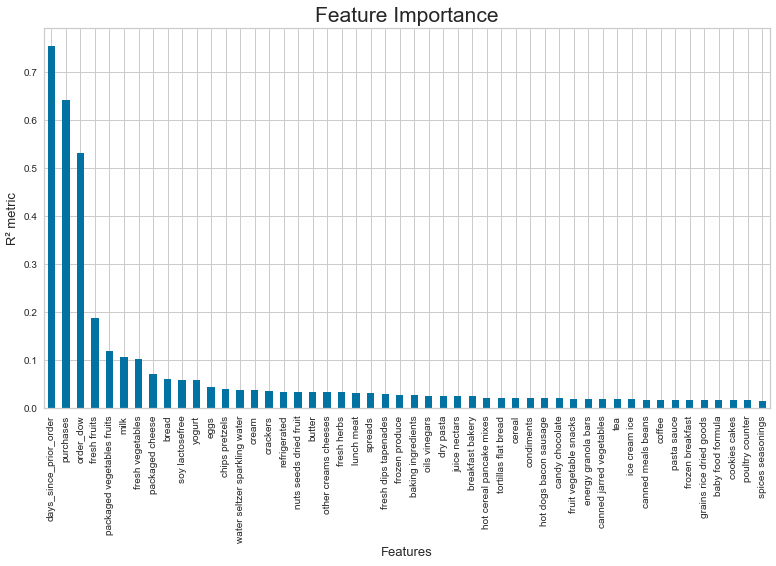

In [36]:
feature_importance = pd.concat((df_scaled, pd.Series(km_labels, name='labels')), axis=1)
feature_importance = r2_variables(feature_importance, "labels").sort_values(ascending=False).drop(["labels"])
# 50 top features
feature_importance[0:50].to_frame().plot.bar(figsize=(13,7))
plt.title("Feature Importance", fontsize=21)
plt.legend().remove()
plt.xlabel("Features", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

We have two different persepectives to be analyzed here: **purchase behavior** and **product types**. <br> The purchase behavior variables seem hereby to be the most important in explaining the cluster compositions.

###  3.2. Basic Analysis

In [37]:
df_clustered = clusters.copy()

In [38]:
df_clustered["labels"] = df_clustered.labels + 1

In [39]:
df_clustered.labels.value_counts()

1    30843
2    30412
3    23543
4    14120
Name: labels, dtype: int64

In [40]:
df_clustered.groupby("labels").mean()

,purchases,days_since_prior_order,order_dow,order_hour_of_day,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
labels,,,,,,,,,,,,,,,,,,,,,
1,12.864345,9.151828,4.409056,13.603018,0.013390,0.082742,0.003988,0.004150,0.163959,0.019940,...,0.134844,0.117985,0.063872,0.087637,0.015498,0.017573,0.023214,0.423954,0.019810,0.675842
2,12.937722,9.684192,1.101421,13.476612,0.009799,0.083520,0.003321,0.003518,0.180883,0.018052,...,0.149185,0.123372,0.065928,0.104860,0.020091,0.016178,0.021702,0.439366,0.013745,0.765915
3,7.389670,27.040493,2.716397,13.654223,0.009515,0.077518,0.002379,0.002676,0.117317,0.014187,...,0.126237,0.098458,0.056620,0.084399,0.014399,0.017542,0.017542,0.360362,0.011638,0.545512
4,51.278754,5.670088,2.804158,13.257688,0.018697,0.219618,0.014873,0.013952,0.673654,0.046530,...,0.418768,0.397025,0.171459,0.270822,0.052762,0.036048,0.074150,1.144972,0.035411,2.203470


### 3.3. Purchase Behavior

In [41]:
pb = df_clustered[["purchases", "days_since_prior_order", "order_dow", "order_hour_of_day", "labels"]]

### Cluster performance per variables compared to overall population

In [42]:
pb_means = pb.groupby("labels").mean()
pb_means = pb_means.append(pb.drop("labels", axis=1).mean(), ignore_index=True)
pb_means["Cluster"] = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Average"]

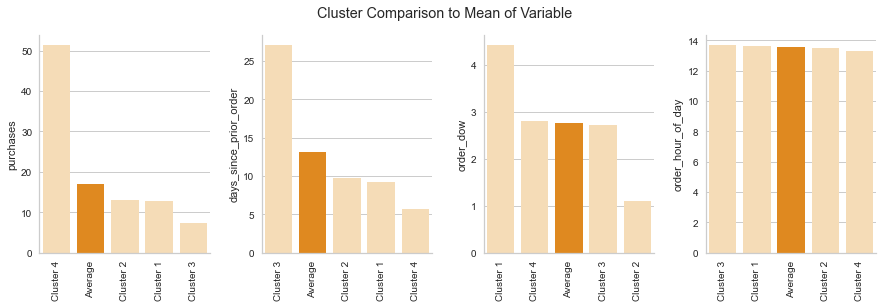

In [43]:
#ceil(len(features) / 3
fig, axes = plt.subplots(1,4 , figsize=(15, 4))

metric_features = pb_means.columns.to_list()
for ax, feat in zip(axes.flatten(), metric_features):
    sns.barplot(x="Cluster", y = feat, data=pb_means.sort_values(feat, ascending=False), 
                palette=["navajowhite" if x!='Average' else 'darkorange' for x in pb_means.sort_values(
                feat, ascending=False).Cluster], 
                ax=ax).set(xlabel='')
    sns.despine(right=True)
    
title = "Cluster Comparison to Mean of Variable"
plt.suptitle(title)

# Rotating X-axis labels
axes.flatten()[0].tick_params(axis='x', labelrotation = 90)
axes.flatten()[1].tick_params(axis='x', labelrotation = 90)
axes.flatten()[2].tick_params(axis='x', labelrotation = 90)
axes.flatten()[3].tick_params(axis='x', labelrotation = 90)
plt.subplots_adjust(wspace=0.3, hspace=0.7)

plt.show()

### Box plotting the purchase behavior

In [44]:
def box_plot(df, x, y, title):
    
    # set figure parameters
    plt.rcParams['figure.figsize'] = (12,4)

    # box plots
    plt.subplot(1,2,1)
    sns.boxplot(data=df, x=x, y=y, palette='Set1_r', showfliers=False)
    plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

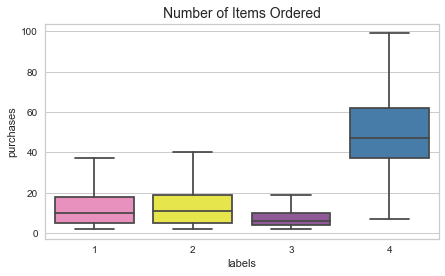

In [45]:
box_plot(df_clustered,'labels','purchases','Number of Items Ordered')

Here one can see huge disrepancies between the three clusters regarding the number of times they ordered at Instacart. Cluster 3 has the lowest population but is the cluster that orders the most compared to the others. <br> Loyal shoppers? Or really frequent shoppers?

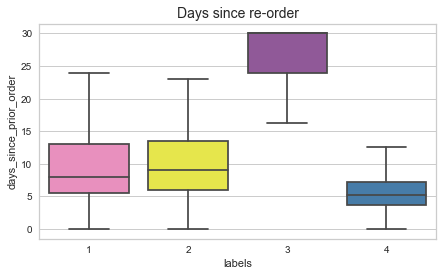

In [46]:
box_plot(df_clustered,'labels','days_since_prior_order','Days since re-order')

Cluster 3: most recent shoppers too, so comming back to the findings above a shopper of Cluster 3 might be a frequent buyer.

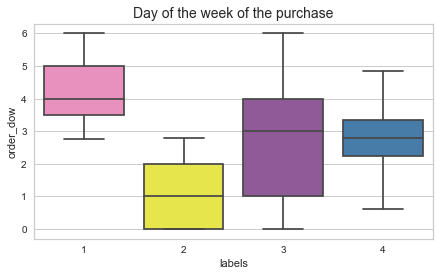

In [47]:
box_plot(df_clustered,'labels','order_dow','Day of the week of the purchase')

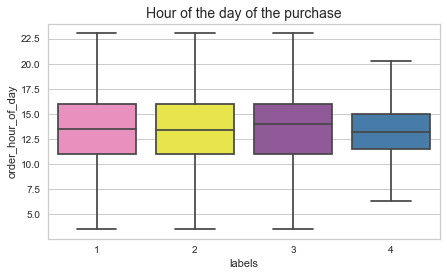

In [48]:
box_plot(df_clustered,'labels','order_hour_of_day','Hour of the day of the purchase')

### Kernel Density Estimate plots for purchase behaviour

**What are Kernel Density Estimate plots?** <br>
KDE Plot described as Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable. It depicts the probability density at different values in a continuous variable. 

In [49]:
my_data = df_clustered.sample(frac=0.2)
print("--- Shape:\n",my_data.shape)
my_data.head()

--- Shape:
 (19784, 139)


,purchases,days_since_prior_order,order_dow,order_hour_of_day,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,labels
30663,31,13.0,2.0,15.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
81421,4,29.5,0.0,18.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
34418,26,6.0,2.0,15.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
90109,2,27.0,6.0,19.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
33737,20,8.5,4.0,12.00,0,0,0,0,1,0,...,0,0,0,0,0,0,4,0,0,1


### Purchase behaviour (Purchase vs. all)

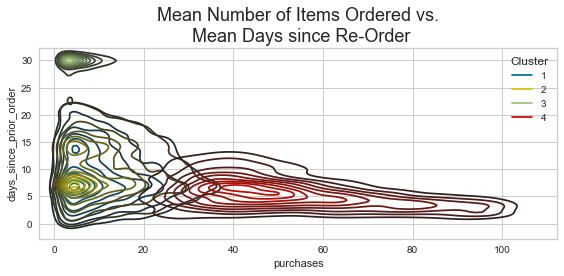

In [50]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.labels==1].purchases, my_data[my_data.labels==1].days_since_prior_order, shade=False, shade_lowest=False, color='b', label='1')
sns.kdeplot(my_data[my_data.labels==2].purchases, my_data[my_data.labels==2].days_since_prior_order, shade=False, shade_lowest=False, color='y', label='2')
sns.kdeplot(my_data[my_data.labels==3].purchases, my_data[my_data.labels==3].days_since_prior_order, shade=False, shade_lowest=False, color='g', label='3')
sns.kdeplot(my_data[my_data.labels==4].purchases, my_data[my_data.labels==4].days_since_prior_order, shade=False, shade_lowest=False, color='r', label='4')
# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Number of Items Ordered vs.\n Mean Days since Re-Order', fontsize=18)

plt.tight_layout()
plt.show()

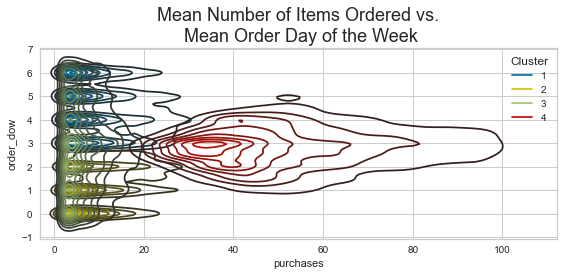

In [51]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.labels==1].purchases, my_data[my_data.labels==1].order_dow, shade=False, shade_lowest=False, color='b', label='1')
sns.kdeplot(my_data[my_data.labels==2].purchases, my_data[my_data.labels==2].order_dow, shade=False, shade_lowest=False, color='y', label='2')
sns.kdeplot(my_data[my_data.labels==3].purchases, my_data[my_data.labels==3].order_dow, shade=False, shade_lowest=False, color='g', label='3')
sns.kdeplot(my_data[my_data.labels==4].purchases, my_data[my_data.labels==4].order_dow, shade=False, shade_lowest=False, color='r', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Number of Items Ordered vs.\n Mean Order Day of the Week', fontsize=18)

plt.tight_layout()
plt.show()

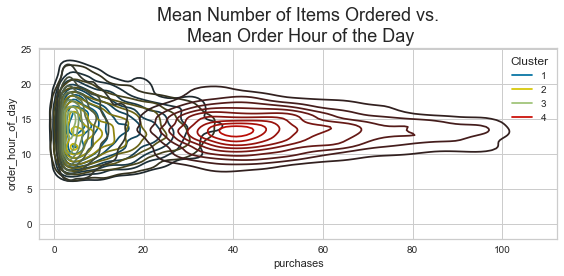

In [52]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.labels==1].purchases, my_data[my_data.labels==1].order_hour_of_day, shade=False, shade_lowest=False, color='b', label='1')
sns.kdeplot(my_data[my_data.labels==2].purchases, my_data[my_data.labels==2].order_hour_of_day, shade=False, shade_lowest=False, color='y', label='2')
sns.kdeplot(my_data[my_data.labels==3].purchases, my_data[my_data.labels==3].order_hour_of_day, shade=False, shade_lowest=False, color='g', label='3')
sns.kdeplot(my_data[my_data.labels==4].purchases, my_data[my_data.labels==4].order_hour_of_day, shade=False, shade_lowest=False, color='r', label='4')


# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Number of Items Ordered vs.\n Mean Order Hour of the Day', fontsize=18)

plt.tight_layout()
plt.show()

### Purchase behaviour (Days since re-order vs. all)

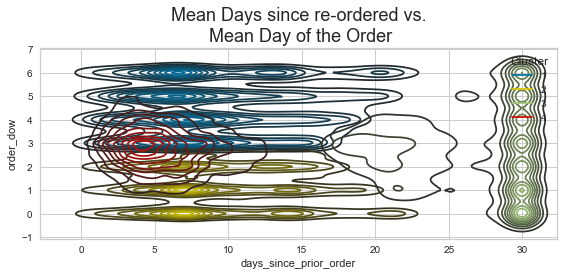

In [53]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.labels==1].days_since_prior_order, my_data[my_data.labels==1].order_dow, shade=False, shade_lowest=False, color='b', label='1')
sns.kdeplot(my_data[my_data.labels==2].days_since_prior_order, my_data[my_data.labels==2].order_dow, shade=False, shade_lowest=False, color='y', label='2')
sns.kdeplot(my_data[my_data.labels==3].days_since_prior_order, my_data[my_data.labels==3].order_dow, shade=False, shade_lowest=False, color='g', label='3')
sns.kdeplot(my_data[my_data.labels==4].days_since_prior_order, my_data[my_data.labels==4].order_dow, shade=False, shade_lowest=False, color='r', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Days since re-ordered vs.\n Mean Day of the Order', fontsize=18)

plt.tight_layout()
plt.show()

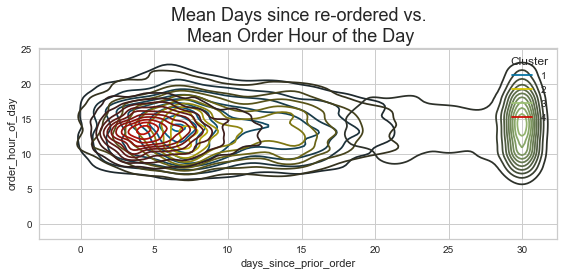

In [54]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.labels==1].days_since_prior_order, my_data[my_data.labels==1].order_hour_of_day, shade=False, shade_lowest=False, color='b', label='1')
sns.kdeplot(my_data[my_data.labels==2].days_since_prior_order, my_data[my_data.labels==2].order_hour_of_day, shade=False, shade_lowest=False, color='y', label='2')
sns.kdeplot(my_data[my_data.labels==3].days_since_prior_order, my_data[my_data.labels==3].order_hour_of_day, shade=False, shade_lowest=False, color='g', label='3')
sns.kdeplot(my_data[my_data.labels==4].days_since_prior_order, my_data[my_data.labels==4].order_hour_of_day, shade=False, shade_lowest=False, color='r', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Days since re-ordered vs.\n Mean Order Hour of the Day', fontsize=18)

plt.tight_layout()
plt.show()

### 3.4. Analysis Based on Product Types

In [55]:
product_types = df_clustered.loc[:,"air fresheners candles":]

In [56]:
products_labels = product_types.groupby("labels").mean()
products_labels.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
labels,,,,,,,,,,,,,,,,,,,,,
1,0.013390,0.082742,0.003988,0.004150,0.163959,0.019940,0.163830,0.013358,0.003664,0.037837,...,0.134844,0.117985,0.063872,0.087637,0.015498,0.017573,0.023214,0.423954,0.019810,0.675842
2,0.009799,0.083520,0.003321,0.003518,0.180883,0.018052,0.158293,0.010522,0.002992,0.020584,...,0.149185,0.123372,0.065928,0.104860,0.020091,0.016178,0.021702,0.439366,0.013745,0.765915
3,0.009515,0.077518,0.002379,0.002676,0.117317,0.014187,0.137153,0.011214,0.003058,0.017585,...,0.126237,0.098458,0.056620,0.084399,0.014399,0.017542,0.017542,0.360362,0.011638,0.545512
4,0.018697,0.219618,0.014873,0.013952,0.673654,0.046530,0.452833,0.027975,0.006516,0.046246,...,0.418768,0.397025,0.171459,0.270822,0.052762,0.036048,0.074150,1.144972,0.035411,2.203470


In [57]:
products_c1 = products_labels.iloc[[0]]
products_c2 = products_labels.iloc[[1]]
products_c3 = products_labels.iloc[[2]]
products_c4 = products_labels.iloc[[3]]

### Cluster performance per product types compared to overall population - Top 20

In [58]:
top_20 = feature_importance[3:23].reset_index()["index"].to_list()

In [59]:
pt_means = products_labels[top_20].append(product_types[top_20].mean(), ignore_index=True)
pt_means["Cluster"] = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Average"]
pt_means

,fresh fruits,packaged vegetables fruits,milk,fresh vegetables,packaged cheese,bread,soy lactosefree,yogurt,eggs,chips pretzels,...,cream,crackers,refrigerated,nuts seeds dried fruit,butter,other creams cheeses,fresh herbs,lunch meat,spreads,Cluster
0,1.672730,0.823915,0.413287,1.603897,0.469701,0.279674,0.300360,0.675842,0.215478,0.358655,...,0.155108,0.219855,0.290698,0.139481,0.122783,0.150310,0.180171,0.186071,0.134844,Cluster 1
1,1.911022,0.940681,0.441175,1.832599,0.519598,0.296100,0.321945,0.765915,0.234184,0.377680,...,0.160693,0.235927,0.291365,0.155366,0.122386,0.153985,0.192194,0.211594,0.149185,Cluster 2
2,1.316442,0.704116,0.313681,1.418129,0.416217,0.235314,0.254980,0.545512,0.200102,0.322856,...,0.115321,0.199762,0.224525,0.125175,0.112305,0.129550,0.152657,0.161279,0.126237,Cluster 3
3,5.600425,2.527479,1.427408,4.760907,1.375354,0.851983,0.937252,2.203470,0.610127,0.968980,...,0.486615,0.638952,0.834632,0.460482,0.362252,0.433569,0.537323,0.544334,0.418768,Cluster 4
4,2.221850,1.074476,0.542914,2.080643,0.601589,0.355860,0.387109,0.890576,0.273904,0.443104,...,0.194676,0.279838,0.352797,0.186781,0.154350,0.186933,0.228300,0.239158,0.177733,Average


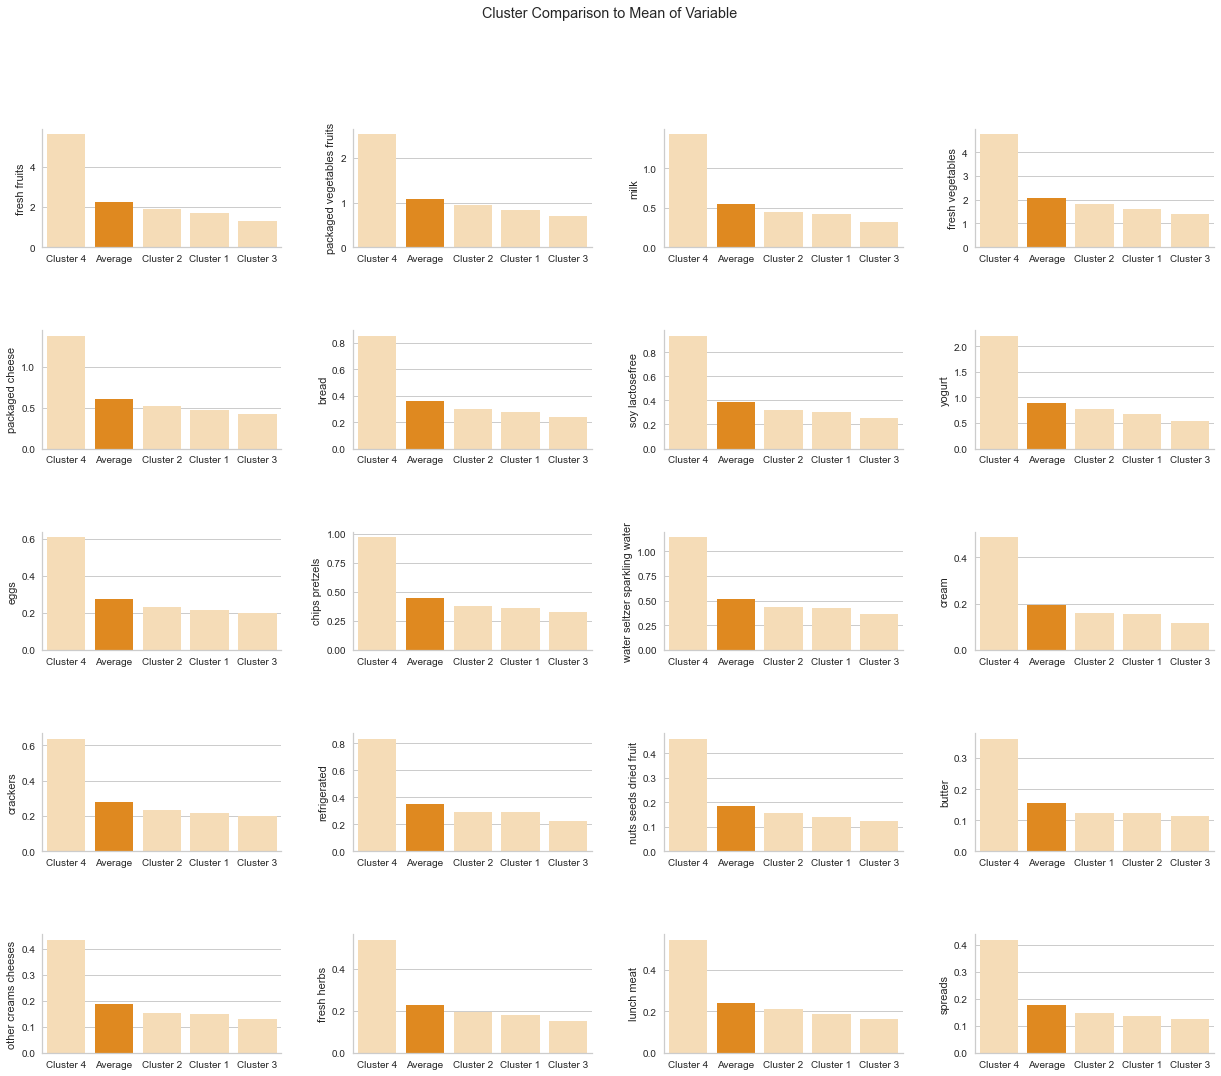

In [60]:
#ceil(len(features) / 3
fig, axes = plt.subplots(5,4 , figsize=(21, 17))

metric_features = pt_means.columns.to_list()
for ax, feat in zip(axes.flatten(), metric_features):
    sns.barplot(x="Cluster", y = feat, data=pt_means.sort_values(feat, ascending=False), 
                palette=["navajowhite" if x!='Average' else 'darkorange' for x in pt_means.sort_values(
                feat, ascending=False).Cluster], 
                ax=ax).set(xlabel='')
    sns.despine(right=True)
    
title = "Cluster Comparison to Mean of Variable"
plt.suptitle(title)


plt.subplots_adjust(wspace=0.3, hspace=0.7)

plt.show()

### Top 20 Products per Cluster 

In [61]:
products_c1.T.sort_values(by=[1],ascending=False)[:20]

labels,1
fresh fruits,1.672730
fresh vegetables,1.603897
packaged vegetables fruits,0.823915
yogurt,0.675842
packaged cheese,0.469701
water seltzer sparkling water,0.423954
milk,0.413287
chips pretzels,0.358655
soy lactosefree,0.300360
refrigerated,0.290698


In [62]:
products_c2.T.sort_values(by=[2],ascending=False)[:20]

labels,2
fresh fruits,1.911022
fresh vegetables,1.832599
packaged vegetables fruits,0.940681
yogurt,0.765915
packaged cheese,0.519598
milk,0.441175
water seltzer sparkling water,0.439366
chips pretzels,0.377680
soy lactosefree,0.321945
bread,0.296100


In [63]:
products_c3.T.sort_values(by=[3],ascending=False)[:20]

labels,3
fresh vegetables,1.418129
fresh fruits,1.316442
packaged vegetables fruits,0.704116
yogurt,0.545512
packaged cheese,0.416217
water seltzer sparkling water,0.360362
chips pretzels,0.322856
milk,0.313681
soy lactosefree,0.254980
bread,0.235314


In [64]:
products_c4.T.sort_values(by=[4],ascending=False)[:20]

labels,4
fresh fruits,5.600425
fresh vegetables,4.760907
packaged vegetables fruits,2.527479
yogurt,2.203470
milk,1.427408
packaged cheese,1.375354
water seltzer sparkling water,1.144972
chips pretzels,0.968980
soy lactosefree,0.937252
bread,0.851983


## 4. MBA per Cluster

### 4.1. Transform and shape dataframe to re-apply MBA on selected cluster

In [65]:
user_labels = pd.concat((df_clustered.labels, users_df.reset_index().user_id), axis=1)

In [66]:
mba_merge = user_labels.merge(orders[["order_id", "user_id"]], how="left", on="user_id")
mba_merge = mba_merge.merge(order_prod, how="left", on="order_id").drop("user_id", axis=1)
mba_merge = pd.merge(mba_merge, products, how='left', on='product_id').\
            drop(["product_id", "department_id"], axis=1)

In [67]:
# prepared table for MBA
mba_merge.head()

,labels,order_id,product_name
0,1,1901567,fresh fruits
1,1,1901567,popcorn jerky
2,1,1901567,lunch meat
3,1,1901567,packaged cheese
4,1,1901567,prepared soups salads


### Dividing the df based on their cluster labels

In [68]:
cluster_one = mba_merge.loc[mba_merge.labels == 1].drop("labels", axis=1)
cluster_two = mba_merge.loc[mba_merge.labels == 2].drop("labels", axis=1)
cluster_three = mba_merge.loc[mba_merge.labels == 3].drop("labels", axis=1)
cluster_four = mba_merge.loc[mba_merge.labels == 4].drop("labels", axis=1)

In [69]:
cluster_four.head()

,order_id,product_name
130,771049,water seltzer sparkling water
131,771049,coffee
132,771049,energy granola bars
133,2305567,breakfast bakery
134,2305567,juice nectars


In [70]:
# create function to perform MBA for each cluster based df
def create_pivot(df):
    pt = df.pivot_table(index='order_id', columns='product_name', 
                        aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
    return pt

In [71]:
pt_one = create_pivot(cluster_one)
pt_one.shape

(50896, 134)

In [72]:
pt_two = create_pivot(cluster_two)
pt_two.shape

(50987, 134)

In [73]:
pt_three = create_pivot(cluster_three)
pt_three.shape

(31801, 134)

In [74]:
pt_four = create_pivot(cluster_four)
pt_four.shape

(59961, 134)

#### Check if equal with inital df length 
(new orders not included (kicked them out) therefore not equal to 200k here)

In [75]:
pt_one.shape[0] + pt_two.shape[0] + pt_three.shape[0] + pt_four.shape[0]

193645

In [76]:
user_labels.merge(orders[["order_id", "user_id"]], how="left", on="user_id").shape[0]

193645

## 4.2. MBA for Cluster 2 - Frequent shoppers 
Most profitable buyers

In [77]:
pt_two.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
147,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 4.2.1 Support

In [78]:
# Apply the APRIORI algorithm to get frequent itemsets
frequent_itemsets_freq = apriori(pt_two, min_support=0.05, use_colnames=True)
frequent_itemsets_freq.head()

,support,itemsets
0,0.072175,(baking ingredients)
1,0.159374,(bread)
2,0.068096,(breakfast bakery)
3,0.068900,(butter)
4,0.067586,(candy chocolate)


### 4.2.2 Support itemsets - Frequent shoppers

In [79]:
frequent_itemsets_freq.sort_values(by='support', ascending=False).reset_index(drop=True).head(20)

,support,itemsets
0,0.567772,(fresh fruits)
1,0.455371,(fresh vegetables)
2,0.376880,(packaged vegetables fruits)
3,0.328672,"(fresh fruits, fresh vegetables)"
4,0.279797,"(packaged vegetables fruits, fresh fruits)"
5,0.269716,(yogurt)
6,0.243356,"(packaged vegetables fruits, fresh vegetables)"
7,0.234864,(milk)
8,0.233118,(packaged cheese)
9,0.194324,(water seltzer sparkling water)


In [80]:
# Complementary and substitute products
rulesLift2_freq = association_rules(frequent_itemsets_freq, metric="lift", min_threshold=0.01)

In [81]:
rulesLift2_freq['length_ant'] = rulesLift2_freq['antecedents'].apply(lambda x: len(x))
rulesLift2_freq['length_cons'] = rulesLift2_freq['consequents'].apply(lambda x: len(x))

### 4.2.3 Complementary itemsets for frequent shoppers

In [82]:
# Complementary products
rulesLift2_freq.sort_values(by='lift', ascending=False, inplace=True)
rulesLift2_freq_com = rulesLift2_freq[(rulesLift2_freq['length_ant'] <= 1) &
                                    (rulesLift2_freq['length_cons'] <= 1) &
                                    (rulesLift2_freq['conviction'] > 1.3)].sort_values(
    by=['lift','conviction'], ascending = False).reset_index(drop=True)
rulesLift2_freq_com.iloc[:,:9]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh herbs),(fresh vegetables),0.093004,0.455371,0.079589,0.855757,1.879253,0.037238,3.775776
1,(canned jarred vegetables),(fresh vegetables),0.075490,0.455371,0.058897,0.780203,1.713334,0.024521,2.477869
2,(canned meals beans),(fresh vegetables),0.075000,0.455371,0.054916,0.732218,1.607958,0.020763,2.033849
3,(fresh herbs),(packaged vegetables fruits),0.093004,0.376880,0.053170,0.571700,1.516926,0.018119,1.454866
4,(fresh dips tapenades),(packaged vegetables fruits),0.098476,0.376880,0.054700,0.555467,1.473855,0.017587,1.401740
5,(frozen produce),(packaged vegetables fruits),0.127229,0.376880,0.069920,0.549561,1.458183,0.021970,1.383360
6,(soup broth bouillon),(fresh vegetables),0.087003,0.455371,0.057250,0.658025,1.445031,0.017631,1.592600
7,(packaged vegetables fruits),(fresh vegetables),0.376880,0.455371,0.243356,0.645712,1.417991,0.071736,1.537249
8,(fresh vegetables),(packaged vegetables fruits),0.455371,0.376880,0.243356,0.534413,1.417991,0.071736,1.338353
9,(frozen produce),(fresh vegetables),0.127229,0.455371,0.081570,0.641128,1.407926,0.023634,1.517615


### 4.2.4 Heatmap - Complementary itemsets for frequent shoppers

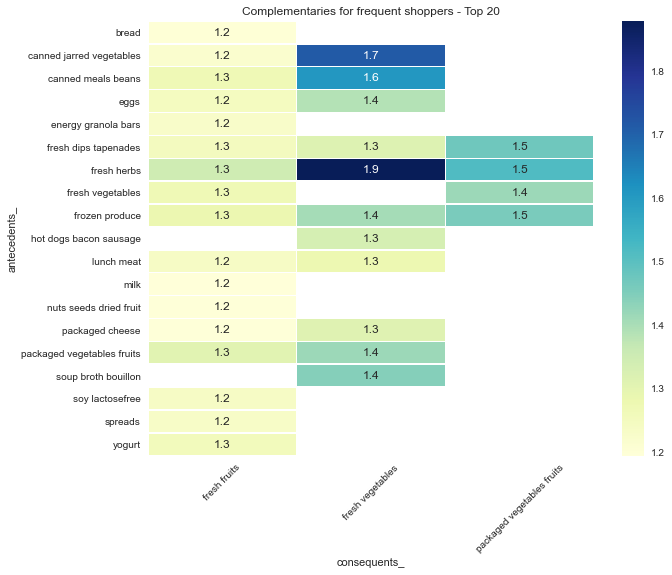

In [83]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
rulesLift2_freq_com['antecedents_'] = rulesLift2_freq_com['antecedents'].apply(lambda a: ','.join(list(a)))
rulesLift2_freq_com['consequents_'] = rulesLift2_freq_com['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rulesLift2_freq_com[rulesLift2_freq_com['length_ant']==1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(pivot, annot = True,linewidths=.5,ax=ax, cmap="YlGnBu").set_title("Complementaries for frequent shoppers - Top 20")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.savefig('Freq_coms_heatmap.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()

In [84]:
# Function to convert rules to coordinates.
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

In [85]:
coords = rules_to_coordinates(rulesLift2_freq_com.iloc[:,:9])

In [86]:
coords

,antecedent,consequent,rule
0,fresh herbs,fresh vegetables,0
1,canned jarred vegetables,fresh vegetables,1
2,canned meals beans,fresh vegetables,2
3,fresh herbs,packaged vegetables fruits,3
4,fresh dips tapenades,packaged vegetables fruits,4
5,frozen produce,packaged vegetables fruits,5
6,soup broth bouillon,fresh vegetables,6
7,packaged vegetables fruits,fresh vegetables,7
8,fresh vegetables,packaged vegetables fruits,8
9,frozen produce,fresh vegetables,9


### 4.2.6 Parallel Coordinates Graph

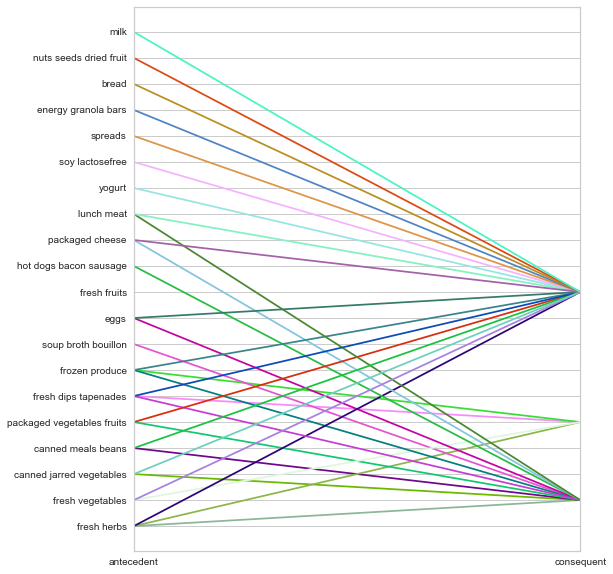

In [87]:
plt.figure(figsize=(8,10))
pd.plotting.parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.savefig('Freq_coms_coordination.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()

### 4.2.7 Substitute itemsets for frequent shoppers

In [88]:
# Apply the APRIORI algorithm to get frequent itemsets
frequent_itemsets_freq = apriori(pt_two, min_support=0.025, use_colnames=True)
frequent_itemsets_freq.head()

,support,itemsets
0,0.041854,(asian foods)
1,0.040991,(baby food formula)
2,0.072175,(baking ingredients)
3,0.159374,(bread)
4,0.068096,(breakfast bakery)


In [89]:
# Complementary and substitute products
rulesLift2_freq = association_rules(frequent_itemsets_freq, metric="lift", min_threshold=0.01)

In [90]:
rulesLift2_freq['length_ant'] = rulesLift2_freq['antecedents'].apply(lambda x: len(x))
rulesLift2_freq['length_cons'] = rulesLift2_freq['consequents'].apply(lambda x: len(x))

In [91]:
# Substitue products
rulesLift2_freq.sort_values(by='lift', ascending=False, inplace=True)
rulesLift2_freq_sub = rulesLift2_freq[(rulesLift2_freq['length_ant'] <= 1) &
                                    (rulesLift2_freq['length_cons'] <= 1) &
                                    (rulesLift2_freq['lift'] < 1)].sort_values(
    by=['lift','conviction'], ascending = True).reset_index(drop=True)
rulesLift2_freq_sub.iloc[:,:9]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh vegetables),(soft drinks),0.455371,0.083943,0.026850,0.058963,0.702416,-0.011375,0.973455
1,(soft drinks),(fresh vegetables),0.083943,0.455371,0.026850,0.319860,0.702416,-0.011375,0.800760
2,(soft drinks),(fresh fruits),0.083943,0.567772,0.039696,0.472897,0.832900,-0.007964,0.820007
3,(fresh fruits),(soft drinks),0.567772,0.083943,0.039696,0.069916,0.832900,-0.007964,0.984919
4,(candy chocolate),(fresh vegetables),0.067586,0.455371,0.026752,0.395821,0.869228,-0.004025,0.901437
5,(fresh vegetables),(candy chocolate),0.455371,0.067586,0.026752,0.058748,0.869228,-0.004025,0.990610
6,(soy lactosefree),(milk),0.165277,0.234864,0.035401,0.214192,0.911986,-0.003417,0.973694
7,(milk),(soy lactosefree),0.234864,0.165277,0.035401,0.150731,0.911986,-0.003417,0.982871
8,(paper goods),(fresh fruits),0.061879,0.567772,0.032342,0.522662,0.920550,-0.002791,0.905497
9,(fresh fruits),(paper goods),0.567772,0.061879,0.032342,0.056962,0.920550,-0.002791,0.994787


### 4.2.8 Heatmap - Substitute itemsets for frequent shoppers

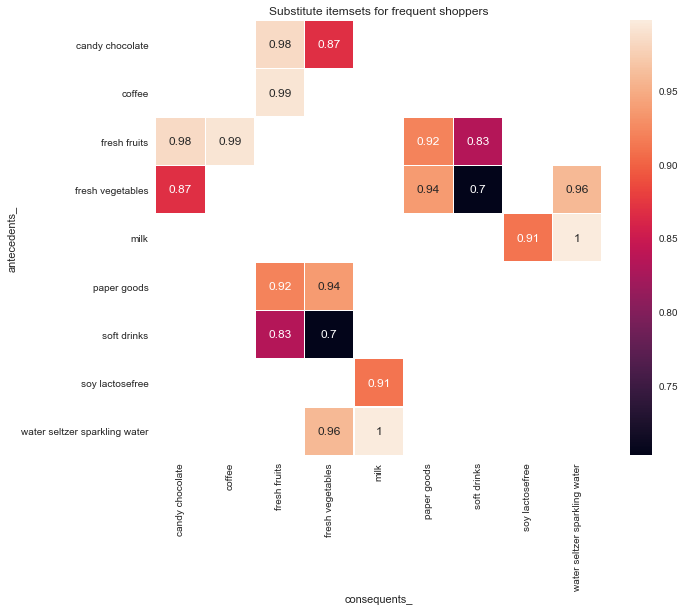

In [92]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
rulesLift2_freq_sub['antecedents_'] = rulesLift2_freq_sub['antecedents'].apply(lambda a: ','.join(list(a)))
rulesLift2_freq_sub['consequents_'] = rulesLift2_freq_sub['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rulesLift2_freq_sub[rulesLift2_freq_sub['length_ant']==1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(pivot, annot = True,linewidths=.5,ax=ax).set_title("Substitute itemsets for frequent shoppers")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.savefig('heatmap_freq_sub.png',bbox_inches='tight',dpi=250)
plt.show()

## 4.3. MBA for Cluster 3 - Occasional shoppers

In [93]:
pt_three.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.3.1 Support

In [94]:
# Apply the APRIORI algorithm to get frequent itemsets
frequent_itemsets_occ = apriori(pt_three, min_support=0.05, use_colnames=True)
frequent_itemsets_occ.head()

,support,itemsets
0,0.075564,(baking ingredients)
1,0.160184,(bread)
2,0.064338,(breakfast bakery)
3,0.078237,(butter)
4,0.059747,(candy chocolate)


### 4.3.2 Support itemsets descending by support value

In [95]:
frequent_itemsets_occ.sort_values(by='support', ascending=False).reset_index(drop=True).head(20)

,support,itemsets
0,0.500456,(fresh fruits)
1,0.427754,(fresh vegetables)
2,0.345272,(packaged vegetables fruits)
3,0.296846,"(fresh fruits, fresh vegetables)"
4,0.245590,"(packaged vegetables fruits, fresh fruits)"
5,0.243231,(yogurt)
6,0.230747,(packaged cheese)
7,0.226691,"(packaged vegetables fruits, fresh vegetables)"
8,0.210717,(milk)
9,0.197950,(water seltzer sparkling water)


In [96]:
# Complementary and substitute products
rulesLift2_occ = association_rules(frequent_itemsets_occ, metric="lift", min_threshold=0.01)

In [97]:
rulesLift2_occ['length_ant'] = rulesLift2_occ['antecedents'].apply(lambda x: len(x))
rulesLift2_occ['length_cons'] = rulesLift2_occ['consequents'].apply(lambda x: len(x))

### 4.3.3 Complementary itemsets for occasional shoppers

In [98]:
# Complementary products
rulesLift2_occ.sort_values(by='lift', ascending=False, inplace=True)
rulesLift2_occ_com = rulesLift2_occ[(rulesLift2_occ['length_ant'] <= 1) &
                                    (rulesLift2_occ['length_cons'] <= 1) &
                                    (rulesLift2_occ['lift'] > 1) &
                                    (rulesLift2_occ['conviction'] >= 1.3)].sort_values(
    by=['lift','conviction'], ascending = False).reset_index(drop=True)
rulesLift2_occ_com.iloc[:,:9]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh herbs),(fresh vegetables),0.088834,0.427754,0.075627,0.851327,1.990227,0.037628,3.849037
1,(canned jarred vegetables),(fresh vegetables),0.076130,0.427754,0.057357,0.753408,1.761311,0.024792,2.320616
2,(canned meals beans),(fresh vegetables),0.075564,0.427754,0.054244,0.717853,1.678191,0.021921,2.028182
3,(frozen produce),(packaged vegetables fruits),0.127229,0.345272,0.068897,0.541522,1.568393,0.024969,1.428048
4,(fresh vegetables),(packaged vegetables fruits),0.427754,0.345272,0.226691,0.529957,1.534895,0.078999,1.392909
5,(packaged vegetables fruits),(fresh vegetables),0.345272,0.427754,0.226691,0.656557,1.534895,0.078999,1.666206
6,(fresh dips tapenades),(packaged vegetables fruits),0.105060,0.345272,0.055596,0.529183,1.532654,0.019322,1.390620
7,(soup broth bouillon),(fresh vegetables),0.093834,0.427754,0.061445,0.654826,1.530847,0.021307,1.657847
8,(frozen produce),(fresh vegetables),0.127229,0.427754,0.081601,0.641374,1.499400,0.027179,1.595664
9,(fresh herbs),(fresh fruits),0.088834,0.500456,0.065281,0.734867,1.468395,0.020824,1.884128


In [99]:
rulesLift2_occ_com_20 = rulesLift2_occ_com[:20]

### 4.3.4 Complementary itemsets for occasional shoppers - Top 20

<ipython-input-100-4d239b021c36>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rulesLift2_occ_com_20['antecedents_'] = rulesLift2_occ_com_20['antecedents'].apply(lambda a: ','.join(list(a)))
<ipython-input-100-4d239b021c36>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rulesLift2_occ_com_20['consequents_'] = rulesLift2_occ_com_20['consequents'].apply(lambda a: ','.join(list(a)))


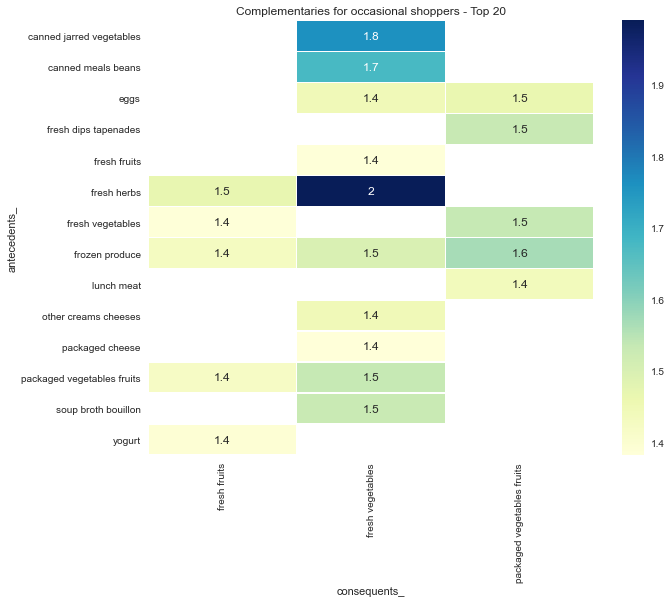

In [100]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
rulesLift2_occ_com_20['antecedents_'] = rulesLift2_occ_com_20['antecedents'].apply(lambda a: ','.join(list(a)))
rulesLift2_occ_com_20['consequents_'] = rulesLift2_occ_com_20['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rulesLift2_occ_com_20[rulesLift2_occ_com_20['length_ant']==1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(pivot, annot = True,linewidths=.5,ax=ax, cmap="YlGnBu").set_title("Complementaries for occasional shoppers - Top 20")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.savefig('Occ_coms_heatmap.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()

### 4.3.5 Substitute itemsets for occasional shoppers

In [101]:
rulesLift2_occ

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_ant,length_cons
201,(fresh herbs),"(fresh fruits, fresh vegetables)",0.088834,0.296846,0.058363,0.656991,2.213239,0.031993,2.049959,1,2
196,"(fresh fruits, fresh vegetables)",(fresh herbs),0.296846,0.088834,0.058363,0.196610,2.213239,0.031993,1.134152,2,1
376,"(yogurt, fresh vegetables)","(fresh fruits, packaged vegetables fruits)",0.141285,0.245590,0.073928,0.523258,2.130620,0.039230,1.582430,2,2
373,"(fresh fruits, packaged vegetables fruits)","(yogurt, fresh vegetables)",0.245590,0.141285,0.073928,0.301024,2.130620,0.039230,1.228534,2,2
200,(fresh vegetables),"(fresh fruits, fresh herbs)",0.427754,0.065281,0.058363,0.136440,2.090050,0.030439,1.082403,1,2
...,...,...,...,...,...,...,...,...,...,...,...
235,(water seltzer sparkling water),"(fresh fruits, fresh vegetables)",0.197950,0.296846,0.060973,0.308022,1.037650,0.002212,1.016151,1,2
84,(water seltzer sparkling water),(fresh fruits),0.197950,0.500456,0.101884,0.514694,1.028451,0.002818,1.029339,1,1
85,(fresh fruits),(water seltzer sparkling water),0.500456,0.197950,0.101884,0.203582,1.028451,0.002818,1.007071,1,1
113,(fresh vegetables),(water seltzer sparkling water),0.427754,0.197950,0.083488,0.195178,0.985995,-0.001186,0.996555,1,1


In [102]:
# Substitute products
rulesLift2_occ.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2_occ_sub = rulesLift2_occ[(rulesLift2_occ['length_ant'] == 1) &
                                    (rulesLift2_occ['length_cons'] == 1) &
                                    (rulesLift2_occ['lift'] < 1)].sort_values(by='lift', ascending = True).reset_index(drop=True)
rulesLift2_occ_sub.iloc[:,:9]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(water seltzer sparkling water),(fresh vegetables),0.197950,0.427754,0.083488,0.421763,0.985995,-0.001186,0.989640
1,(fresh vegetables),(water seltzer sparkling water),0.427754,0.197950,0.083488,0.195178,0.985995,-0.001186,0.996555


### 4.3.6 Heatmap - Substitute itemsets for occasional shoppers

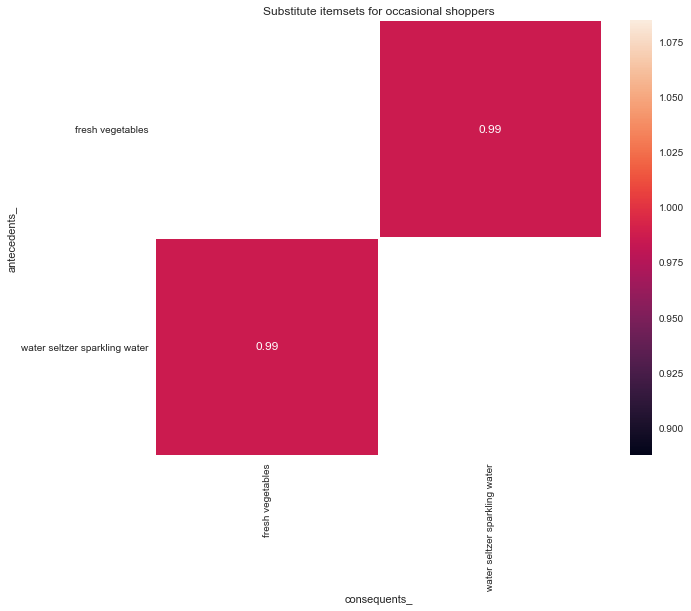

In [103]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
rulesLift2_occ_sub['antecedents_'] = rulesLift2_occ_sub['antecedents'].apply(lambda a: ','.join(list(a)))
rulesLift2_occ_sub['consequents_'] = rulesLift2_occ_sub['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rulesLift2_occ_sub[rulesLift2_occ_sub['length_ant']==1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(pivot, annot = True,linewidths=.5,ax=ax).set_title("Substitute itemsets for occasional shoppers")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.savefig('heatmap_sub_occ_20.png',bbox_inches='tight',dpi=250)
plt.show()

In [104]:
rulesLift2_occ_com_20

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_ant,length_cons,antecedents_,consequents_
0,(fresh herbs),(fresh vegetables),0.088834,0.427754,0.075627,0.851327,1.990227,0.037628,3.849037,1,1,fresh herbs,fresh vegetables
1,(canned jarred vegetables),(fresh vegetables),0.076130,0.427754,0.057357,0.753408,1.761311,0.024792,2.320616,1,1,canned jarred vegetables,fresh vegetables
2,(canned meals beans),(fresh vegetables),0.075564,0.427754,0.054244,0.717853,1.678191,0.021921,2.028182,1,1,canned meals beans,fresh vegetables
3,(frozen produce),(packaged vegetables fruits),0.127229,0.345272,0.068897,0.541522,1.568393,0.024969,1.428048,1,1,frozen produce,packaged vegetables fruits
4,(fresh vegetables),(packaged vegetables fruits),0.427754,0.345272,0.226691,0.529957,1.534895,0.078999,1.392909,1,1,fresh vegetables,packaged vegetables fruits
5,(packaged vegetables fruits),(fresh vegetables),0.345272,0.427754,0.226691,0.656557,1.534895,0.078999,1.666206,1,1,packaged vegetables fruits,fresh vegetables
6,(fresh dips tapenades),(packaged vegetables fruits),0.105060,0.345272,0.055596,0.529183,1.532654,0.019322,1.390620,1,1,fresh dips tapenades,packaged vegetables fruits
7,(soup broth bouillon),(fresh vegetables),0.093834,0.427754,0.061445,0.654826,1.530847,0.021307,1.657847,1,1,soup broth bouillon,fresh vegetables
8,(frozen produce),(fresh vegetables),0.127229,0.427754,0.081601,0.641374,1.499400,0.027179,1.595664,1,1,frozen produce,fresh vegetables
9,(fresh herbs),(fresh fruits),0.088834,0.500456,0.065281,0.734867,1.468395,0.020824,1.884128,1,1,fresh herbs,fresh fruits
